<a href="https://colab.research.google.com/github/dukei/dls-fr/blob/master/DLS-project-FR-1_FaceAlignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Alignment

## Выбор датасета

В этом проекте мы будем работать с датасетом [CelebA - Original Wild Images](https://www.kaggle.com/datasets/kevinpatel04/celeba-original-wild-images). Обычно, когда говорят про CelebA имеют ввиду его кропнутую и выровненную версию, но мы будем работать с сырой.

![CelebA](https://figures.semanticscholar.org/7df4f96138a4e23492ea96cf921794fc5287ba72/6-Figure4-1.png)

Оригинальная версия датасета весит очень много: ~20 гб. Все картинки нам не будут нужны, достаточно будет ограничиться 10.000+.

Вашим первым заданием будет подготовить себе рабочий датасет. Он будет использован и в следующих заданиях, поэтому подойдите к этому очень ответственно:

- Скачайте себе датасет CelebA In a Wild любым удобным способом;
- Подумайте над тем, по каким критериям лучше всего выбирать картинки. Используйте файл с атрибутами. Обоснуйте свой выбор текстом. В случае, если обоснования выбора датасета не будет, то баллы могут быть снижены. Отнеситесь к этому серьезно: хорошая подготовка данных очень важна;
- Отберите 10.000+ изображений. Можно и больше при желании;
- При помощи атрибутов bbox'а, обрежьте картинки, чтобы на них остались только лица. При желании можно делать дополнительный кроп, так как не везде разметка идеальна, но не нужно сидеть над каждой картинкой отдельно - потратите слишком много времени;
- Сохраните отдельный csv-файл с оригинальными названиями изображений, которые были отобраны в ваш датасет. В дальнейшем он в том числе понадобится для сдачи проекта.

Несколько практических советов:
- Если решили делать дополнительный кроп изображений самостоятельно, то имейте ввиду, что ключевые точки лица в атрибутах указаны в начальной системе координат.
- Не работайте с датасетом в колабе. Простейшую работу с файлами удобнее всего делать локально на своем компьютере. Это не требует мощного железа и скачивания библиотек. Если все же пользуетесь колабом, то работайте на CPU, чтобы не лишний раз не тратить токены.
- Если есть возможность, то не удаляйте оригинальный датасет с вашего компьютера на период работы над проектом. Да, это лишняя занятая память, но зато при надобности можно будет быстро что-то изменить.
- Загрузите финальный датасет (10.000+ картинок) себе на Google Disk. Это удобнее, чем каждый раз отдельно загружать его себе в колаб сессию.

## Архитектура Stacked Hourglass Network

В разных вариантах пайплайна для распознавания лиц ключевые точки лица могут предсказываться сразу детектором (MTCNN, RetinaFace и прочие), а могут и отдельной моделью. В этом проекте рассматривается второй вариант. То есть, за детекцию ключевых точек будет отвечать отдельная модель.

**Hourglass** — это U-Net-подобная структура, которая сначала уменьшает разрешение изображения, затем восстанавливает его обратно. Такая структура напоминает по форме песочные часы (hourglass).

**Stacked Hourglass Network** состоит Hourglass-блоков, каждый из которых старается уточнять результат предыдущего. Несмотря на то, что она придумана в 2016 году, до сих пор используется во многих исследовательских проектах для задачи обнаружения ключевых точек.

![image](https://img2018.cnblogs.com/blog/900393/201907/900393-20190722093153502-1808128161.png)

### Hourglass module

Посмотрим подробнее на структуру **отдельного Hourglass-блока**

![retrt](https://curt-park.github.io/images/stacked_hourglass_networks/fig3.png)

Каждый бокс в этой схеме - это Residual block, который отвечает за извлечение признаков на разных уровнях детализации (вспоминаем про ResNet). Причем, каждый такой блок имеет одинаковую размерность на входе и на выходе.

Downsampling и upsampling можно делать разными способами.

*   Для Downsampling: nn.MaxPool2d или nn.Conv2d
*   Для Upsampling: nn.Upsample или nn.ConvTranspose2d

Основная разница: maxpool и upsample - необучаемые слои в отличие от сверток. Это может как быть как минусом, так и плюсом: чем больше параметров - тем медленее идет процесс обучения (при этом не факт, что результаты будут лучше).

То есть, идейно все практически также как было в U-net: полностью симметричная архитектура, сначала идет преобразование в более низкоразмерное пространство, а потом декодирование обратно с пробросами результатов из соотвествующих слоев энкодера. Разница лишь в том, что теперь каждый кирпичик - это Residual block.

А вот реализация ResidualBlock вам в помощь!

Но можете ее править под себя, если очень хочется.

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.skip = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, 1)

        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, 1)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels // 2, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels // 2)
        self.conv3 = nn.Conv2d(out_channels // 2, out_channels, 1)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.skip(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        return self.relu(x + residual)

При построении архитектуры Hourglass-блоков **не обязательно полностью повторять архитектуру**, которая представлена на картинке из статьи. Вы можете добавлять больше или меньше модулей, некоторые блоки вообще можно не использовать. В целом, это творческая задача и вы вольны делать так, как вам самим хочется. **Главное - чтобы ваша реализация соотвествовала изначальной идее Hourglass, и итоговые результаты были достаточно хорошими.**

### Stacked Hourglass Network

Как и было сказано ранее, Stacked Hourglass - это набор одинаковых Hourglass блоков (см. схематический рисунок в начале ноутбука). Но что это за блок между каждыми двумя Hourglass? Чтобы ответить на этот вопрос, нужно сначала разобраться с тем, что мы будем получать на выходе такой нейронной сети.

Предсказывать ключевые точки лица можно поразному. Есть два основных подхода:

1.   Регрессия - предсказывает координаты точек лица напрямую -> $(N, x, y)$.
2.   Heatmap - предсказывает карту вероятностей на выходе, а наиболее подходящие точки находятся через argmax

Не вдваясь в подробности, можно просто сказать, что Heatmap-подход показал себя лучше из-за своей устойчивости к шумам и начальным условиям. В качестве функции потерь в таком случае используют обычный **MSE loss**.

В Stacked Hourglass **используется именно heatmap-подход**. И на выходе каждого Hourglass-блока находится слой (голова), который создает heatmap нужного размера. Обычно это какие-то стандартные варианты по типу *Conv -> BatchNorm -> Relu -> Conv* или просто *Conv*. Каждая heatmap'a прокидывается на следующую голову, и они суммируются, и так, пока слои не закончатся.

Такой подход нужен для реализации **Intermediate Supervision**. Если говорить простыми словами, то это такой вариант обучения нейронной сети, когда мы подсчитываем лосс не только по финальному выходу сети, а также на некоторых промежуточных слоях (головах). Градиенты в этом случае тоже распространяются не только через последний выход, но и через промежуточные уровни. Эти головы не влияют на финальное предсказание напрямую, но помогают модели быстрее и лучше учиться. На практике это означет следующее:

Нужно посчитать лосс (таргет для всех одинаковый) для каждой головы отдельно, а потом просуммировать. Далее Pytorch сам построит за вас весь граф вычислений и правильно запустит везде градиенты. В коде это выглядит так:

```
outputs = model(image)  # outputs — список из N heatmaps от разных голов
losses = [loss_function(output, target) for output in outputs]
total_loss = sum(losses)
total_loss.backward()
optimizer.step()
```

Подведем **итоги по архитектуре**.

Stacked Hourglass состоит из Hourglass-блоков, после каждого такого блока идет голова, которая предсказывает heatmap'у. Каждая heatmap'а суммируется с предыдущей. Градиенты при обучении текут с каждой головы, а не только через последний выход сети.

Подробно про Stacked Hourglass Network можно прочитать в [оригинальной статье](https://arxiv.org/pdf/1603.06937).

## Подготовка датасета для обучения

На этом этапе у вас уже должен быть готовый датасет на основе CelebA In A Wild.

В разметке CelebA всего 5 точек:

1.   Левый глаз
2.   Правый глаз
3.   Нос
4.   Левый уголок рта
5.   Правый уголок рта


Единственная проблема заключается в том, что разметка - это именно точки, а не heatmap'ы. Но можно их сгенерировать самостоятельно при помощи гауссовского распределения вокруг размеченных точек. Вот вам функции в помощь. Можете их тоже редактивовать под себя, если нужно.

In [ ]:
import numpy as np

def create_heatmap(size, landmark, sigma=2):
    """
    Создаёт один heatmap с гауссовым ядром вокруг точки.

    :param size: (height, width) — размер heatmap'а
    :param landmark:(x, y) — координаты точки
    :param sigma
    :return: heatmap массив
    """
    x, y = landmark
    h, w = size

    # Обрезаем координаты, чтобы не выйти за пределы изображения
    x = min(max(0, int(x)), w - 1)
    y = min(max(0, int(y)), h - 1)

    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    heatmap = np.exp(-((yy - y)**2 + (xx - x)**2) / (2 * sigma**2))
    return heatmap


def landmarks_to_heatmaps(image_shape, landmarks, sigma=2):
    """
    Преобразует список из N точек в набор из N heatmap'ов.

    :param image_shape: исходный размер изображения (H, W)
    :param landmarks: список из N пар координат [(x1, y1), (x2, y2), ..., (xN, yN),]
    :param sigma:
    :return: массив heatmap'ов вида [N, H, W]
    """
    heatmaps = []

    for (x, y) in landmarks:
        hm = create_heatmap(image_shape, sigma=sigma)
        heatmaps.append(hm)

    return np.array(heatmaps)

## Выравнивание по предсказанным точкам

Существует множество вариантов, как по полученным точкам правильно преобразовать картинку. Главное, что вам нужно понимать - **это задача классического компьютерного зрения** и решается при помощи математики, без нейронок. Вдаваться в подробности конкретных алгоритмов мы не будем.

Можно использовать аффинное преобразование, тогда потребуется только 3 точки, можно, например, искать матрицу гомографии, где может быть использовано больше точек, а может быть, есть еще что-то. Реализовывать эти алгоритмы самим не нужно. Достаточно провести небольшой ресерч и найти готовое решение (но **не готовую нейронку для выравнивания**), лишь бы оно работало. Количество используемых точек тоже выбирайте сами, подойдет любой вариант. Условный ориентир для поиска - библиотека **opencv**. Обязательно приведите примеры того, как работает ваш алгоритм.

# План заданий

По итогу, в этом блоке у вас следующие задачи:

*   Подготовить датасет, сохранить файл с оригинальными названиями изображений
*   Реализовать Hourglass блок
*   Реализовать Stacked Hourglass
*   Преобразовать точки лица в Heatmap'ы
*   Обучить Stacked Hourglass
*   Найти функцию, которая по предсказанным ключевым точкам выравнивает лица на картинке (face alignment)
*   Подготовить датасет с кропнутыми и выровненными лицами для следующего этапа

**P.S. Не забывайте сохранять модели после обучения и выводите промежуточные результаты на экран**



**Удачи! У вас всё получится 💗!**

## Начинаем!

In [4]:
!pip install kaggle protobuf

In [34]:
import os
import kagglehub
import json

dataset_name = 'kevinpatel04/celeba-original-wild-images'
dataset_path = './celeba_dataset/'

source_dir = kagglehub.dataset_download(dataset_name)
source_dir


'/home/dukei/.cache/kagglehub/datasets/kevinpatel04/celeba-original-wild-images/versions/1'

In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

print("Libraries imported successfully.")

Libraries imported successfully.


In [44]:
import gdown

os.makedirs('celeba_dataset', exist_ok=True)

gdown.download("https://drive.google.com/file/d/0B7EVK8r0v71pTzJIdlJWdHczRlU/view", 'celeba_dataset/landmarks.txt', fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pTzJIdlJWdHczRlU
To: /home/dukei/celeba_dataset/landmarks.txt
100%|██████████████████████████████████████████████████████████████████████████████| 12.4M/12.4M [00:00<00:00, 28.5MB/s]


'celeba_dataset/landmarks.txt'

In [46]:
bbox_df = pd.read_csv(os.path.join(source_dir, 'list_bbox_celeba.csv'))
landmarks_df = pd.read_csv('celeba_dataset/landmarks.txt',
                           sep=' ', skiprows=[0, 1], skipinitialspace=True,
                           names=['image_id','lefteye_x','lefteye_y','righteye_x','righteye_y','nose_x','nose_y','leftmouth_x','leftmouth_y','rightmouth_x','rightmouth_y'])

print("Bounding box data loaded successfully. First 5 rows:")
print(bbox_df.head())
print("\nLandmark data loaded successfully. First 5 rows:")
print(landmarks_df.head())

Bounding box data loaded successfully. First 5 rows:
     image_id  x_1  y_1  width  height
0  000001.jpg   95   71    226     313
1  000002.jpg   72   94    221     306
2  000003.jpg  216   59     91     126
3  000004.jpg  622  257    564     781
4  000005.jpg  236  109    120     166

Landmark data loaded successfully. First 5 rows:
     image_id  lefteye_x  lefteye_y  righteye_x  righteye_y  nose_x  nose_y  \
0  000001.jpg        165        184         244         176     196     249   
1  000002.jpg        140        204         220         204     168     254   
2  000003.jpg        244        104         264         105     263     121   
3  000004.jpg        796        539         984         539     930     687   
4  000005.jpg        273        169         328         161     298     172   

   leftmouth_x  leftmouth_y  rightmouth_x  rightmouth_y  
0          194          271           266           260  
1          146          289           226           289  
2          235

Found 202599 image files in total.
Visualizing 15 random images...


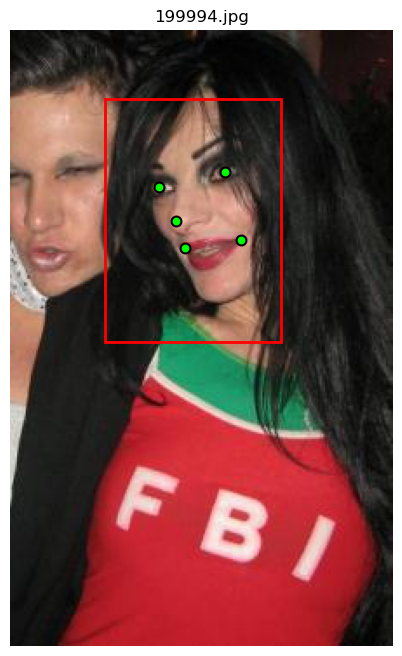

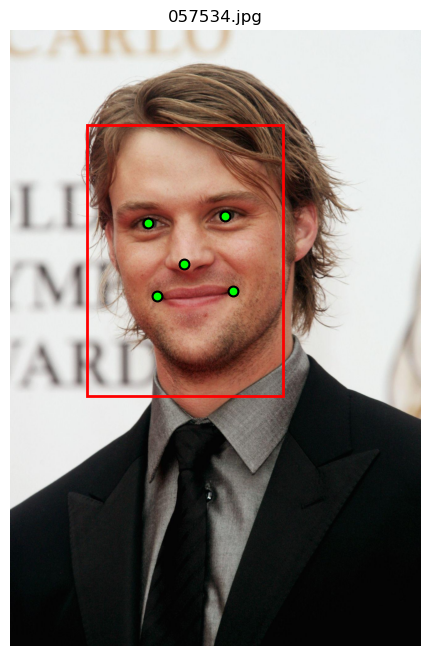

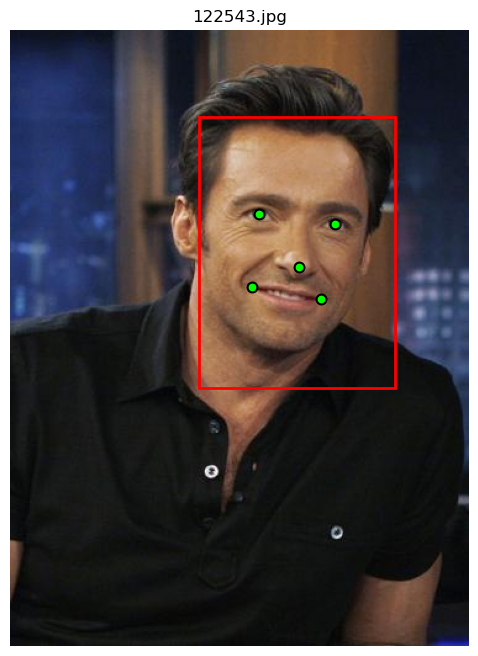

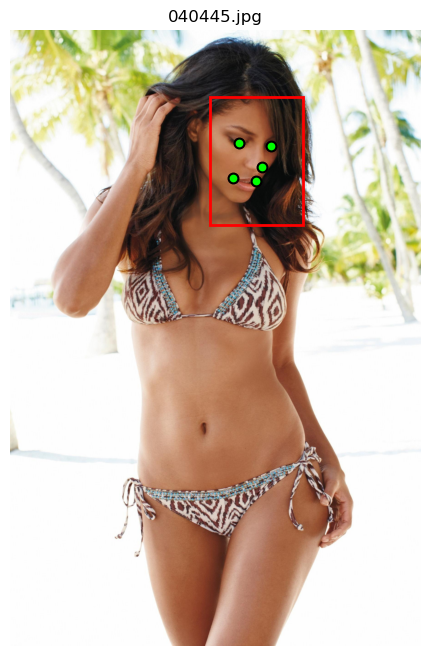

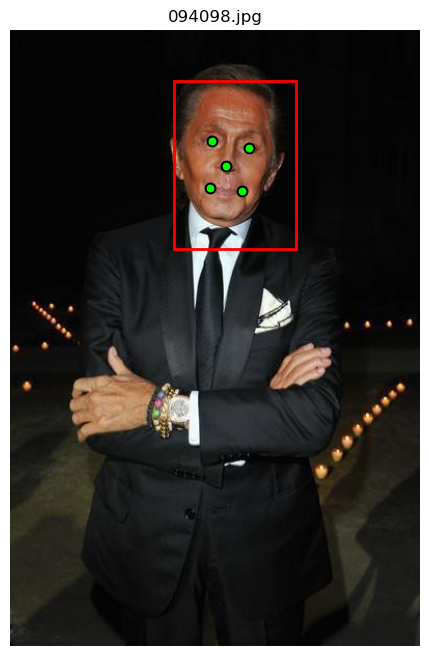

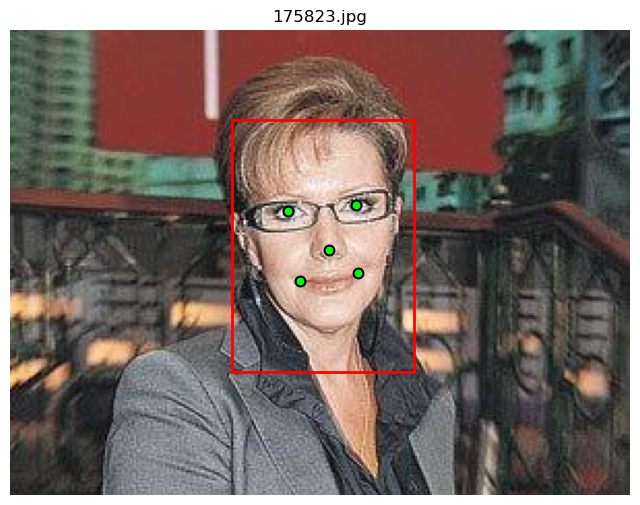

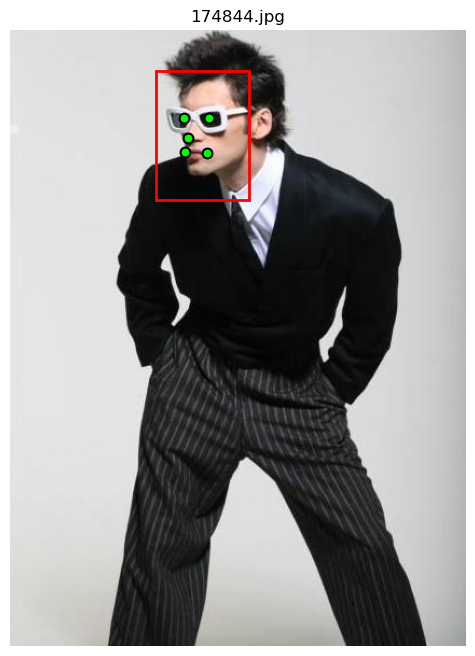

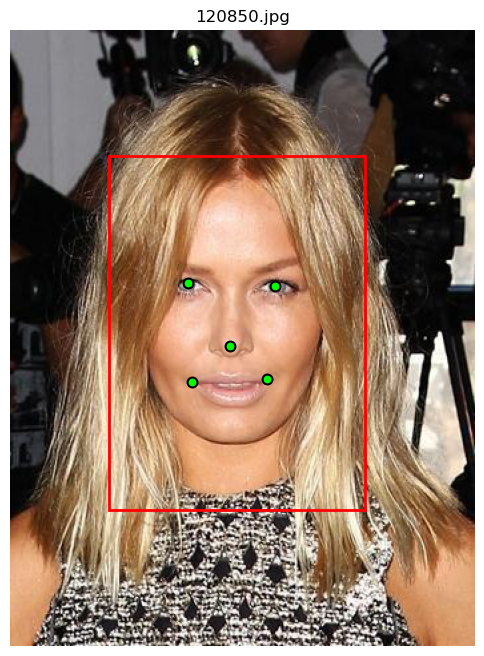

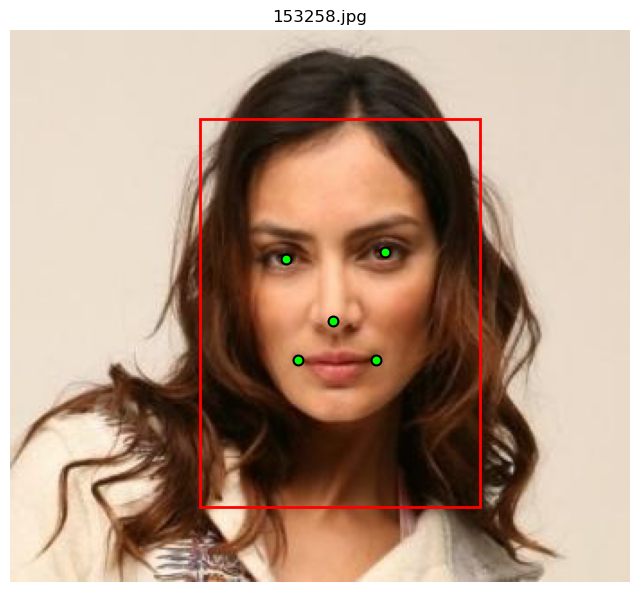

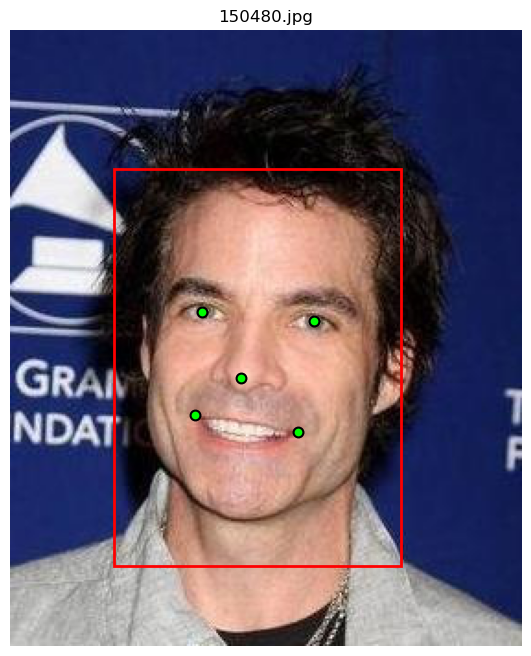

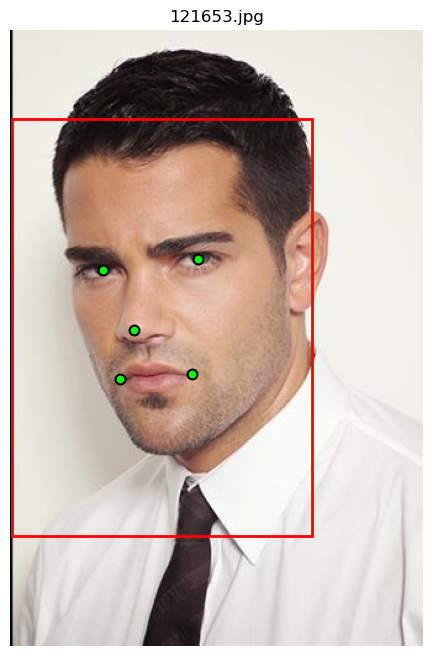

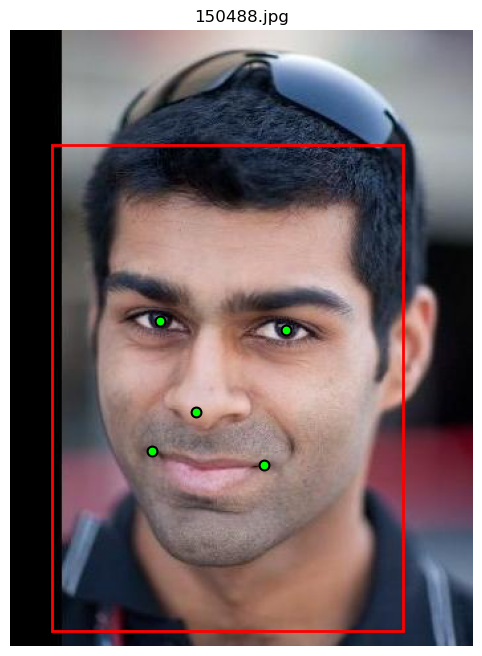

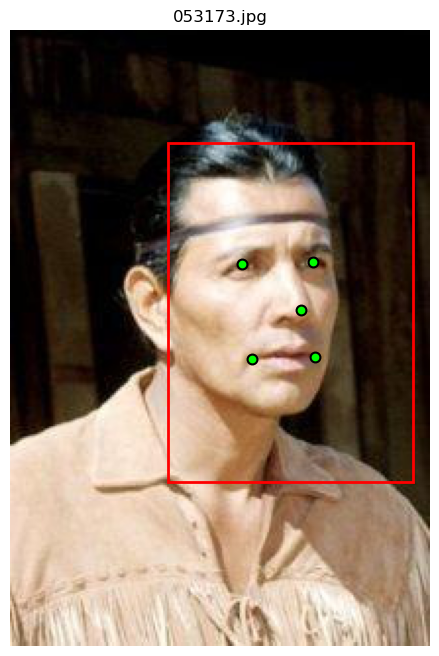

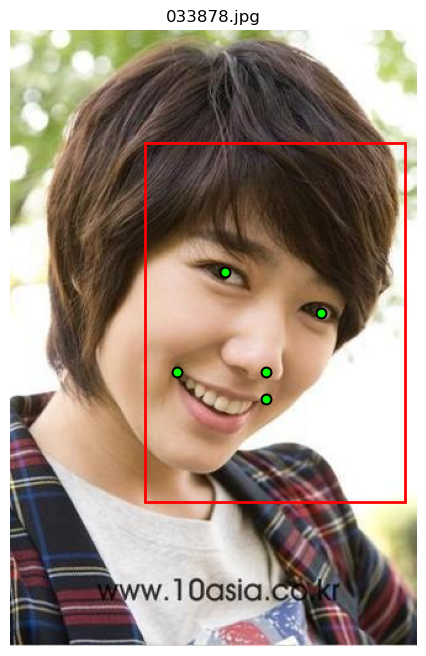

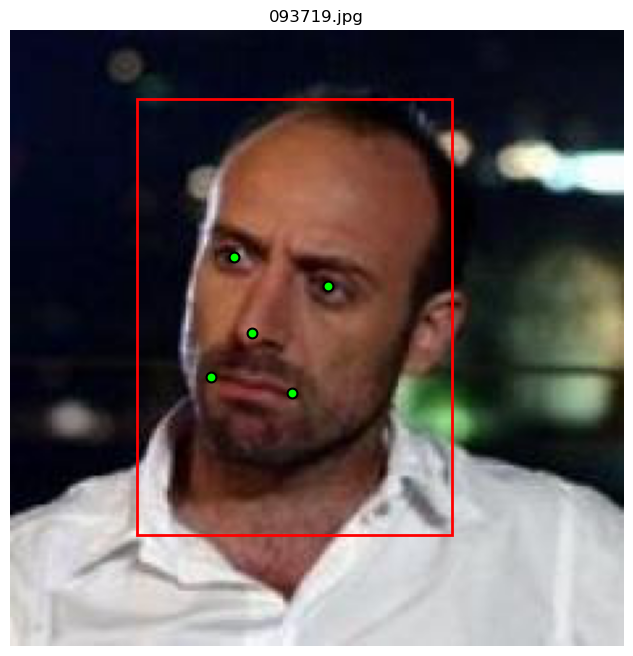

Finished visualizing random images.


In [49]:
def plot_image_with_annotations(image_path, bbox_data, landmarks_data):
    try:
        img = Image.open(image_path)
    except FileNotFoundError:
        print(f"Warning: Image not found at {image_path}. Skipping.")
        return

    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(img)

    # Plot bounding box
    x, y, w, h = bbox_data['x_1'], bbox_data['y_1'], bbox_data['width'], bbox_data['height']
    rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

    # Plot landmarks
    landmark_cols = ['lefteye_x', 'lefteye_y', 'righteye_x', 'righteye_y',
                     'nose_x', 'nose_y', 'leftmouth_x', 'leftmouth_y',
                     'rightmouth_x', 'rightmouth_y']

    # Extract landmark coordinates
    landmarks_x = [landmarks_data[col] for col in landmark_cols if '_x' in col]
    landmarks_y = [landmarks_data[col] for col in landmark_cols if '_y' in col]

    ax.scatter(landmarks_x, landmarks_y, color='lime', s=50, marker='o', edgecolors='black', linewidths=1.5)

    ax.set_title(os.path.basename(image_path))
    ax.axis('off')
    plt.show()

image_files = []
for root, dirs, files in os.walk(source_dir):
    for file in files:
        if file.endswith('.jpg'):
            image_files.append(os.path.join(root, file))

print(f"Found {len(image_files)} image files in total.")

# Select 5 random images
np.random.seed(426) # for reproducibility
# Ensure there are enough images to select from
if len(image_files) >= 5:
    random_images = np.random.choice(image_files, 15, replace=False)
else:
    print(f"Warning: Only {len(image_files)} images found. Visualizing all available images.")
    random_images = image_files

if len(random_images) > 0:
    print(f"Visualizing {len(random_images)} random images...")
    for img_file_path in random_images:
        # Extract the image filename (e.g., '000001.jpg') to match with dataframe
        img_filename = os.path.basename(img_file_path)

        # Retrieve bbox and landmarks for the current image
        bbox_row = bbox_df[bbox_df['image_id'] == img_filename]
        landmarks_row = landmarks_df[landmarks_df['image_id'] == img_filename]

        if not bbox_row.empty and not landmarks_row.empty:
            plot_image_with_annotations(img_file_path, bbox_row.iloc[0], landmarks_row.iloc[0])
        else:
            print(f"Warning: Bounding box or landmark data not found for {img_filename}. Skipping.")

    print("Finished visualizing random images.")
else:
    print("No images to visualize.")
